#  Indicator Search - Network Discovery (IPs)

## Preamble
Within an enterprise network, it is important to conduct in-depth discovery of the nodes communicating to one another.

## Required Data:
Primary data required for this technique are connection logs which may come in various forms such as NetFlow, Bro Logs, Argus, etc.

## Hunt
***Hunt Hypothesis: ***  Through statistical baselining and network graph analysis, are we able to distinguish between normal and abnormal behaviour in the network so that we can detect indicators of compromise when it comes to lateral movement and beaconing.

<hr>

# Scenario

Your Security Analyst colleague has approached you after some reason incidents at AIA related to lateral movement. They would like to explore the network further from a baselining perspective to learn more about normal vs. abnormal behaviour. 

### Data Schema
Name|Type |Description
---|---|---
srcip|nominal|Source IP address
sport|integer|Source port number
dstip|nominal|Destination IP address
dsport|integer|Destination port number
proto|nominal|Transaction protocol
state|nominal|Indicates to the state and its dependent protocol, e.g. ACC, CLO, CON, ECO, ECR, FIN, INT, MAS, PAR, REQ, RST, TST, TXD, URH, URN, and (-) (if not used state)
dur|Float|Record total duration
sbytes|Integer|Source to destination transaction bytes 
dbytes|Integer|Destination to source transaction bytes
sttl|Integer|Source to destination time to live value 
dttl|Integer|Destination to source time to live value
sloss|Integer|Source packets retransmitted or dropped 
dloss|Integer|Destination packets retransmitted or dropped
service|nominal|http, ftp, smtp, ssh, dns, ftp-data ,irc  and (-) if not much used service
Sload|Float|Source bits per second
Dload|Float|Destination bits per second
Spkts|integer|Source to destination packet count 
Dpkts|integer|Destination to source packet count
swin|integer|Source TCP window advertisement value
dwin|integer|Destination TCP window advertisement value
stcpb|integer|Source TCP base sequence number
dtcpb|integer|Destination TCP base sequence number
smeansz|integer|Mean of the ?ow packet size transmitted by the src 
dmeansz|integer|Mean of the ?ow packet size transmitted by the dst 
trans_depth|integer|Represents the pipelined depth into the connection of http request/response transaction
res_bdy_len|integer|Actual uncompressed content size of the data transferred from the servers http service.
Sjit|Float|Source jitter (mSec)
Djit|Float|Destination jitter (mSec)
Stime|Timestamp|record start time
Ltime|Timestamp|record last time
Sintpkt|Float|Source interpacket arrival time (mSec)
Dintpkt|Float|Destination interpacket arrival time (mSec)
tcprtt|Float|TCP connection setup round-trip time, the sum of synack and ackdat.
synack|Float|TCP connection setup time, the time between the SYN and the SYN_ACK packets.
ackdat|Float|TCP connection setup time, the time between the SYN_ACK and the ACK packets.
is_sm_ips_ports|Binary|If source (1) and destination (3)IP addresses equal and port numbers (2)(4)  equal then, this variable takes value 1 else 0
ct_state_ttl|Integer|No. for each state (6) according to specific range of values for source/destination time to live (10) (11).
ct_flw_http_mthd|Integer|No. of flows that has methods such as Get and Post in http service.
is_ftp_login|Binary|If the ftp session is accessed by user and password then 1 else 0. 
ct_ftp_cmd|integer|No of flows that has a command in ftp session.
ct_srv_src|integer|No. of connections that contain the same service (14) and source address (1) in 100 connections according to the last time (26).
ct_srv_dst|integer|No. of connections that contain the same service (14) and destination address (3) in 100 connections according to the last time (26).
ct_dst_ltm|integer|No. of connections of the same destination address (3) in 100 connections according to the last time (26).
ct_src_ ltm|integer|No. of connections of the same source address (1) in 100 connections according to the last time (26).
ct_src_dport_ltm|integer|No of connections of the same source address (1) and the destination port (4) in 100 connections according to the last time (26).
ct_dst_sport_ltm|integer|No of connections of the same destination address (3) and the source port (2) in 100 connections according to the last time (26).
ct_dst_src_ltm|integer|No of connections of the same source (1) and the destination (3) address in in 100 connections according to the last time (26).
attack_cat|nominal|The name of each attack category. In this data set , nine categories e.g. Fuzzers, Analysis, Backdoors, DoS Exploits, Generic, Reconnaissance, Shellcode and Worms
Label|binary|0 for normal and 1 for attack records


# Setup

In [91]:
# Libraries
import pandas as pd
import numpy as np

# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

import networkx as nx

pd.options.display.max_rows = 1000
pd.options.display.max_columns = 20

# Data Ingestion

### Data Schema - Feature Dictionary

In [92]:
 # Connect to Azure Blob
STORAGEACCOUNTNAME= 'ingestionlayer'
STORAGEACCOUNTKEY= '8dHachiwN5Gzd8HAXpnPDedbdDP5qrm7LtwVFv8WA7ww18FhOgaVIqvPLwZHZpZX1RCJ4HTaQAUXoACb0VjQ/Q=='
LOCALFILENAME= 'NUSW-NB15_features.csv'
CONTAINERNAME= 'data'
BLOBNAME= 'data/NUSW-NB15_features.csv'

# Download UNSW TCPDUMP from blob storage
blob_service=BlockBlobService(account_name=STORAGEACCOUNTNAME,account_key=STORAGEACCOUNTKEY)
blobstring = blob_service.get_blob_to_text(CONTAINERNAME, BLOBNAME, encoding='iso-8859-1').content

# Get schema
features_df = pd.read_csv(StringIO(blobstring), encoding='iso-8859-1', index_col='No.')

features_df.head()

,Name,Type,Description
No.,,,
1,srcip,nominal,Source IP address
2,sport,integer,Source port number
3,dstip,nominal,Destination IP address
4,dsport,integer,Destination port number
5,proto,nominal,Transaction protocol


### TCP DUMP Metadata

In [93]:
 # Connect to Azure Blob
STORAGEACCOUNTNAME= 'ingestionlayer'
STORAGEACCOUNTKEY= '8dHachiwN5Gzd8HAXpnPDedbdDP5qrm7LtwVFv8WA7ww18FhOgaVIqvPLwZHZpZX1RCJ4HTaQAUXoACb0VjQ/Q=='
LOCALFILENAME= 'UNSW-NB15_1.csv'
CONTAINERNAME= 'data'
BLOBNAME= 'data/UNSW-NB15_1.csv'

# Download UNSW TCPDUMP from blob storage
blob_service=BlockBlobService(account_name=STORAGEACCOUNTNAME,account_key=STORAGEACCOUNTKEY)
blobstring = blob_service.get_blob_to_text(CONTAINERNAME,BLOBNAME).content
df = pd.read_csv(StringIO(blobstring), header=None)

# Assigned column headers using the features dataframe
df.columns = features_df['Name'].T
df.reset_index(drop=True, inplace=True)

df.head()

Name,srcip,sport,dstip,dsport,proto,state,dur,sbytes,dbytes,sttl,...,ct_ftp_cmd,ct_srv_src,ct_srv_dst,ct_dst_ltm,ct_src_ ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,attack_cat,Label
0,59.166.0.0,1390,149.171.126.6,53,udp,CON,0.001055,132,164,31,...,0,3,7,1,3,1,1,1,NaN,0
1,59.166.0.0,33661,149.171.126.9,1024,udp,CON,0.036133,528,304,31,...,0,2,4,2,3,1,1,2,NaN,0
2,59.166.0.6,1464,149.171.126.7,53,udp,CON,0.001119,146,178,31,...,0,12,8,1,2,2,1,1,NaN,0
3,59.166.0.5,3593,149.171.126.5,53,udp,CON,0.001209,132,164,31,...,0,6,9,1,1,1,1,1,NaN,0
4,59.166.0.3,49664,149.171.126.0,53,udp,CON,0.001169,146,178,31,...,0,7,9,1,1,1,1,1,NaN,0


# Explorative Hunt Analysis

### Network Graph Analysis

Wall time: 4.48 s


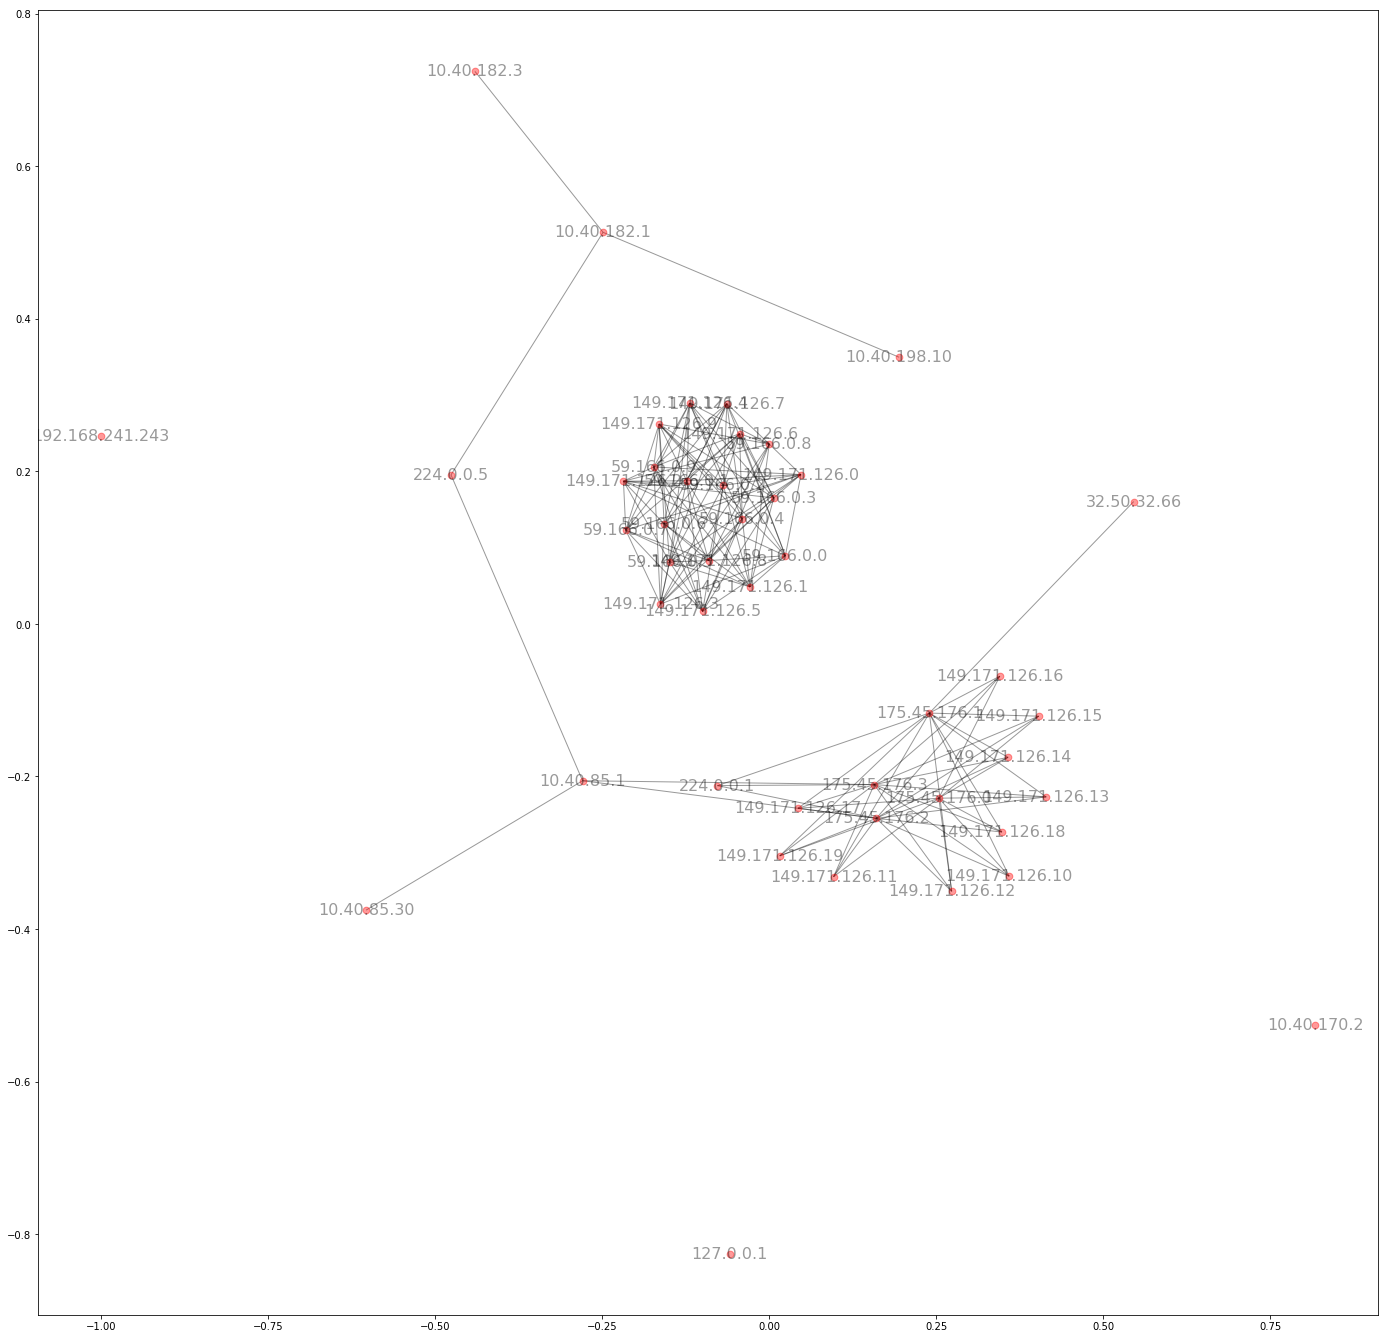

In [94]:
%%time

# Assign to ID by dstip
df = df.assign(id=(df['dstip']).astype('category').cat.codes)

# Groupby dstip
df['id'] = df.groupby(['dstip']).ngroup()

# Generate edge list
g = nx.from_pandas_edgelist(df, 'srcip', 'dstip', ['sbytes', 'dbytes'])

# Initiate spring layout
pos = nx.spring_layout(g, iterations=10)

# Build edge list
ip_nx = nx.from_pandas_edgelist(df, 'srcip', 'dstip', ['sbytes', 'dbytes'])

# Setup Figure
plt.figure(figsize = (24,24))

# Draw network
nx.draw_networkx(ip_nx, pos, node_size=45, alpha=0.4, font_size=16, with_labels=True)

## Long tail analysis - Hosts

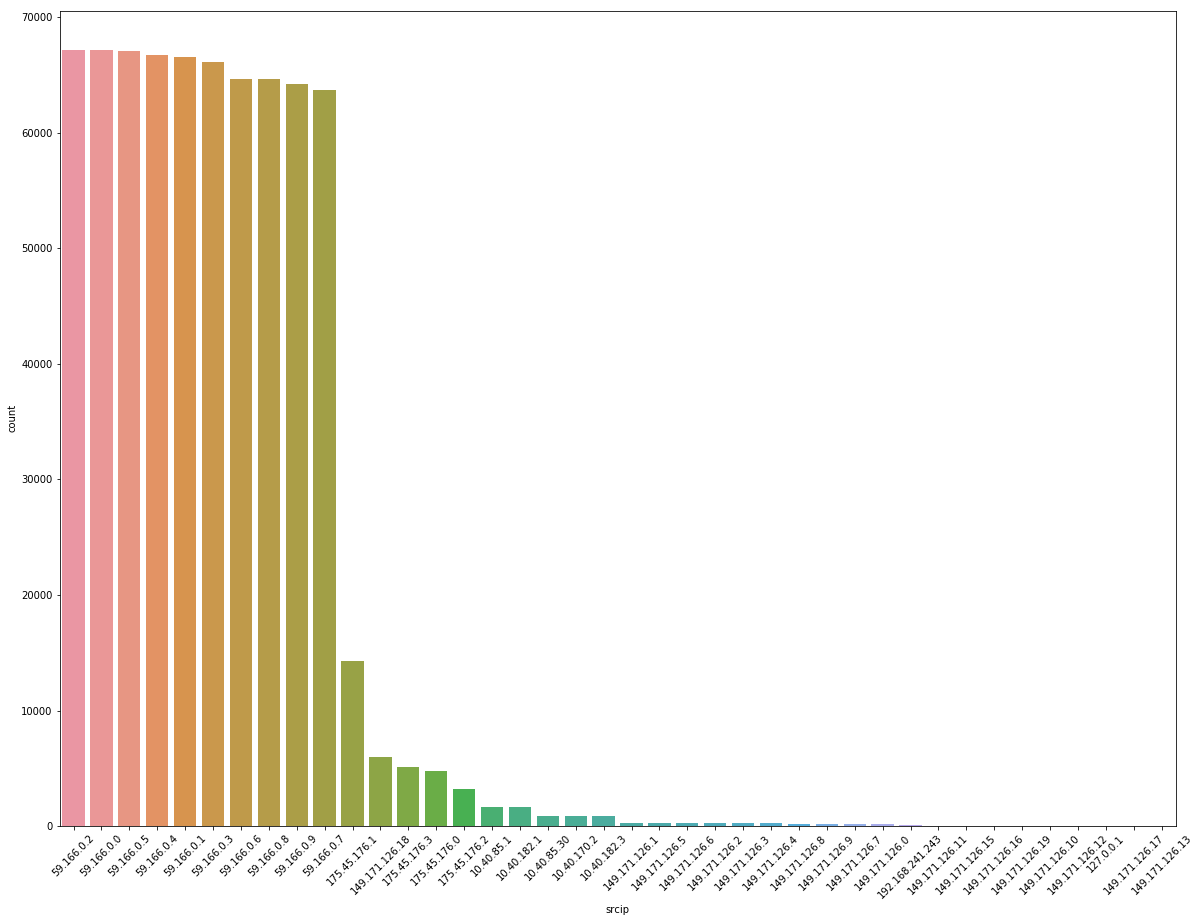

In [95]:
# Plot distribution for source IP
plt.figure(figsize=(20,15))
ax = sns.countplot(x="srcip", data=df, order = df['srcip'].value_counts().index)
for tick in ax.get_xticklabels():
    tick.set_rotation(45)

In [96]:
# Tail of source IP
df['srcip'].value_counts().tail()

149.171.126.10    3
149.171.126.12    2
127.0.0.1         1
149.171.126.17    1
149.171.126.13    1
Name: srcip, dtype: int64

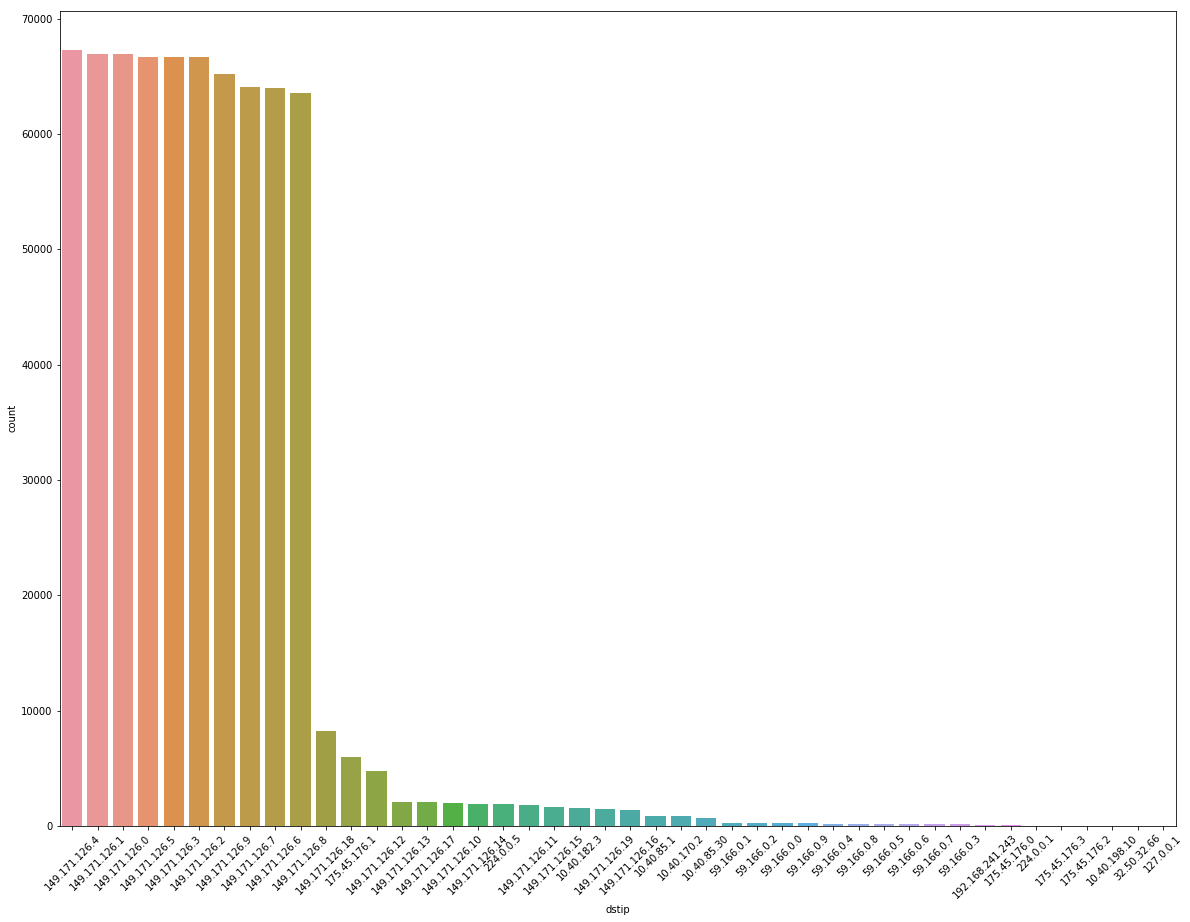

In [97]:
# Plot distribution for destination IP
plt.figure(figsize=(20,15))
ax = sns.countplot(x="dstip", data=df, order = df['dstip'].value_counts().index)
for tick in ax.get_xticklabels():
    tick.set_rotation(45)

In [98]:
# Tail of destination IP
df['dstip'].value_counts().tail()

175.45.176.3    10
175.45.176.2    10
10.40.198.10     6
32.50.32.66      2
127.0.0.1        1
Name: dstip, dtype: int64

## Next Steps

* Explore candidate features associated with hosts and how they relate to TTPs (e.g. Ports)
* Explore feasibility of building a model to detect anomalous activity in the network
* Validate nodes on the network to determine potential candidates for whitelisting
* Determine metrics and baseline for network behaviour in a subset of the network (e.g. Finance Users)
* Explore ports associated with the certain IPs across the network (i.e. non-standard ports)